In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path

import hardware

In [2]:
def mjd_to_hours(mjd):
    seconds_per_day = 86400  # 24 hours * 60 minutes * 60 seconds
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd.iloc[0]) * 24
    
    return hours_since_start


In [3]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.99 # start with full 
print(config)

{'initial': 238.58010000000002, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


## Compare with new model (Night1) 7/24/24

In [4]:
night1_coldpow = pd.read_csv('Night1_Cold Power_354hrEclipse_240724.csv',delimiter=',', header= None)
night1_coldpow = night1_coldpow.T ## flips
night1_coldpow.columns = night1_coldpow.iloc[0] ## sets col
night1_coldpow = night1_coldpow.drop(0) ## reindex
night1_coldpow = night1_coldpow[0:2362] ## end of data
night1_coldpow['tot_sum'] = night1_coldpow['LuSEE Q Total_SUM'].astype(float) + night1_coldpow['POHTR_BATT'].astype(float) + night1_coldpow['Radio_XMIT'].astype(float) 
night1_coldpow=night1_coldpow.loc[:, ~night1_coldpow.columns.duplicated()] ## remove duplicate columns
night1_coldpow['Nodes/Times'] = night1_coldpow['Nodes/Times'].astype(float)

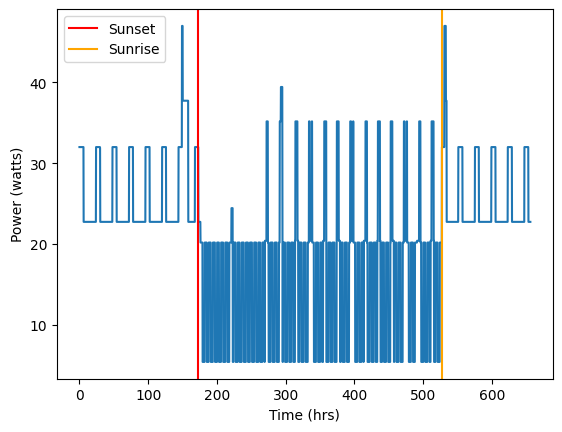

In [5]:
plt.plot(night1_coldpow['Nodes/Times'], night1_coldpow['tot_sum'])
plt.xlabel('Time (hrs)')
plt.ylabel('Power (watts)')
plt.axvline(x = 172.7, color = 'red',label='Sunset')
plt.axvline(x = 527.2, color = 'orange',label='Sunrise')
plt.legend()

In [6]:
# load in solar panels
sol_pvt = pd.read_csv('sol_pow_RevA.csv',delimiter=',') ## loading in solar power data
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['Time (mjd)'])
sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(night1_coldpow['Nodes/Times'])]

print(sol_pvt)
# interp1d lunar power data to the time points of thermal model
interp_func = interp1d(sol_pvt['sol_hrs'], sol_pvt['Solar power (watts)'], fill_value='extrapolate')
lunar_pow_interp = interp_func(pd.to_numeric(night1_coldpow['Nodes/Times']))
print(len(lunar_pow_interp))

      Unnamed: 0    Time (mjd)  Solar power (watts)   Solar X   Solar Y  \
0              0  61050.833333             0.000000  0.999646 -0.025699   
1              1  61050.843750             0.000000  0.999681 -0.024805   
2              2  61050.854167             0.000000  0.999710 -0.023910   
3              3  61050.864583             0.000000  0.999735 -0.023016   
4              4  61050.875000            75.753746  0.999755 -0.022122   
...          ...           ...                  ...       ...       ...   
2619        2619  61078.114583             0.000000  0.872982 -0.205602   
2620        2620  61078.125000             0.000000  0.874058 -0.204819   
2621        2621  61078.135417             0.000000  0.875128 -0.204036   
2622        2622  61078.145833             0.000000  0.876195 -0.203251   
2623        2623  61078.156250             0.000000  0.877257 -0.202465   

       Solar Z  Panel E Temp  Panel W Temp  Panel Top Temp  \
0    -0.006858   -177.456373   -177.4

In [7]:
sunset = 172.7 
sunrise = 527.2

In [8]:
################ begin at sunset  ##################################
night1_coldpow = night1_coldpow[night1_coldpow['Nodes/Times'] > sunset]

In [9]:
colors = ['b','g','k']
T= 0
plt.figure()
B = hardware.Battery(config, verbose=False)
B.set_temperature(T)
energy = 0
deltaT_list= []
soc_values = []
power_values = []
time_list = []
solar_applied = False
solar_index = 0 
sol_cont = []
sunrise_index = None
sunrise_soc = None

for i in range(len(night1_coldpow['Nodes/Times']) - 1):
    deltaT =  3600*(night1_coldpow['Nodes/Times'].iloc[i+1] -night1_coldpow['Nodes/Times'].iloc[i])
    deltaT_list.append(deltaT)
    P = night1_coldpow['tot_sum'].iloc[i] 
    if not solar_applied:
        sol_cont.append(0)
        power_values.append(P)
        B.apply_power(-P,deltaT) # discharge at 1W
        B.apply_age(deltaT)
        energy += deltaT*P
        soc_values.append(B.SOC())
   
    if night1_coldpow['Nodes/Times'].iloc[i] >= sunrise and not solar_applied:
       while solar_index <= (len(night1_coldpow['Nodes/Times'])-i): 
           ### discharging
           deltaT =  3600*(night1_coldpow['Nodes/Times'].iloc[solar_index+1] - night1_coldpow['Nodes/Times'].iloc[solar_index])
           P =night1_coldpow['tot_sum'].iloc[solar_index+i] 
           B.apply_power(-P,deltaT) 
           power_values.append(P)

           ### charging
           P_add = sol_pvt['Solar power (watts)'].iloc[solar_index]
           B.apply_power(P_add, deltaT)
           solar_index += 1
           energy += deltaT*(P_add-P)
           sol_cont.append(P_add)
           soc_values.append(B.SOC())
           
           if len(soc_values) > len(night1_coldpow['Nodes/Times']) - 1:
                   break
           solar_applied = True


<Figure size 640x480 with 0 Axes>

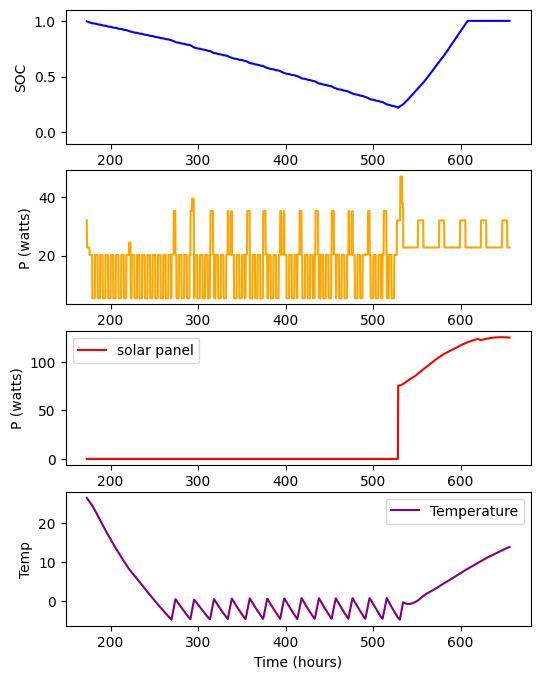

In [10]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(night1_coldpow['Nodes/Times'], soc_values, color ='blue' ,label=T)
plt.ylim(-0.1,1.1)
plt.ylabel('SOC')
plt.subplot(4, 1, 2)
plt.plot(night1_coldpow['Nodes/Times'],power_values, color = 'orange' ,label=T )
plt.ylabel('P (watts)')
plt.subplot(4, 1, 3)
plt.plot(night1_coldpow['Nodes/Times'], sol_cont, color = 'red',label='solar panel')
plt.ylabel('P (watts)')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(night1_coldpow['Nodes/Times'],night1_coldpow['Battery_AVG'], color = 'purple',label='Temperature')
plt.ylabel('Temp')
plt.xlabel('Time (hours)')
plt.legend()

 
plt.show() 

# Ryan's Solar Panel Model

0    LuSEE Q Total_SUM    PMU Q_SUM   PFPS_Q_SUM PDU_Q_SUM DCB_Q_SUM  \
1                   28         1.48            8       0.6         2   
2                   28         1.48            8       0.6         2   
3                 28.0         1.48          8.0       0.6       2.0   
4                 28.0         1.48          8.0       0.6       2.0   
5                 28.0         1.48          8.0       0.6       2.0   
...                ...          ...          ...       ...       ...   
2549             22.74         1.48          8.0       0.6       2.0   
2550              28.0         1.48          8.0       0.6       2.0   
2551                28         1.48            8       0.6         2   
2552               5.4         0.92            1       0.6         2   
2553       18.63865882  1.202415686  5.781176471       0.6         2   

0    Spectrometer_Q_SUM Pre-Amp 1 Q_SUM Pre-Amp 2 Q_SUM Pre-Amp 3 Q_SUM  \
1                     0            0.22            0.22     

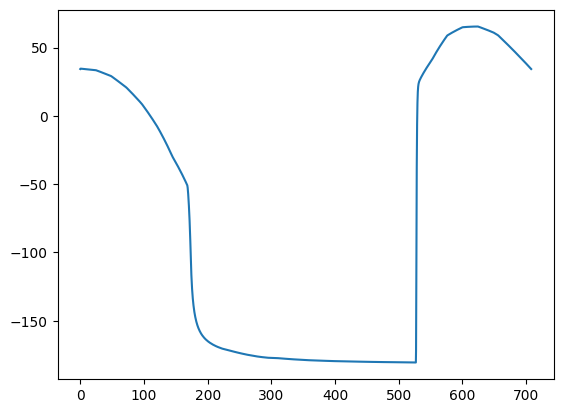

In [17]:
sol_ryan = pd.read_csv('Night1_SolarPanels_354hrEclipse_240725.csv',delimiter=',') 
sol_ryan = sol_ryan.T ## flips
sol_ryan = sol_ryan.reset_index(drop=True) ## sets col
sol_ryan.columns = sol_ryan.iloc[0] ## sets col
sol_ryan = sol_ryan.drop(0) ## reindex
print(sol_ryan)
sol_ryan = sol_ryan[0:2550] ## end of data

sol_ryan=sol_ryan.loc[:, ~sol_ryan.columns.duplicated()] ## remove duplicate columns
sol_ryan['Nodes/Times'] = sol_ryan['Nodes/Times'].astype(float)

sol_ryan['SOLAR_PNL_MX_AVG']= sol_ryan['SOLAR_PNL_MX_AVG'].astype(float)
sol_ryan['SOLAR_PNL_PX_AVG']= sol_ryan['SOLAR_PNL_PX_AVG'].astype(float)
sol_ryan['SOLAR_PNL_PZ_AVG']= sol_ryan['SOLAR_PNL_PZ_AVG'].astype(float)

plt.plot(sol_ryan['Nodes/Times'],sol_ryan['SOLAR_PNL_MX_AVG'])

Text(0.02, 0.5, 'P (watts)')

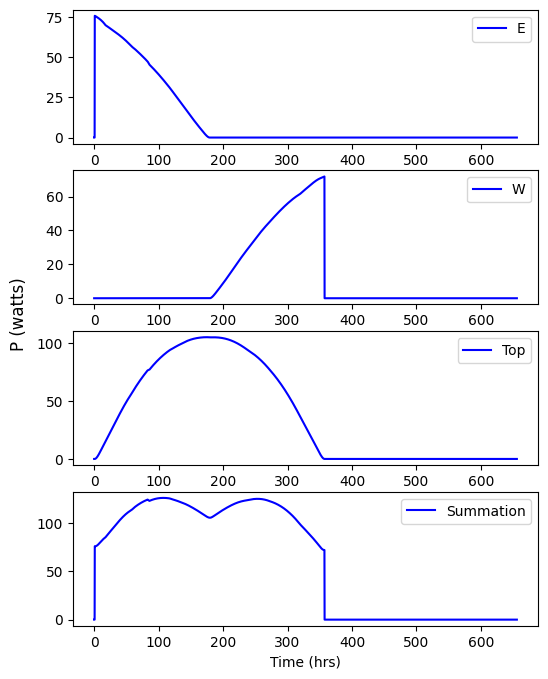

In [18]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel E Power'], color ='blue' ,label='E')

plt.legend()
plt.subplot(4, 1, 2)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel W Power'], color ='blue' ,label='W')

plt.legend()
plt.subplot(4, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel Top Power'], color ='blue' ,label='Top')

plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Solar power (watts)'], color ='blue' ,label='Summation')
plt.xlabel('Time (hrs)')
plt.legend()
fig.supylabel('P (watts)')




Text(0.02, 0.5, 'T (C)')

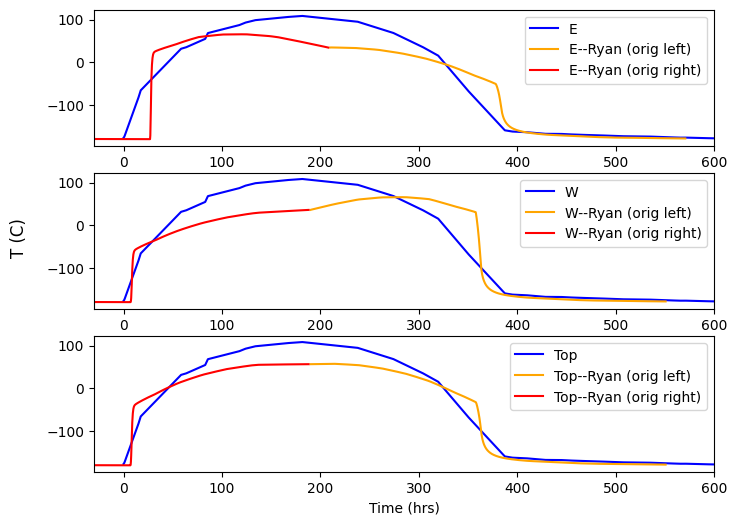

In [57]:


fig =plt.figure(figsize=(8, 6))
plt.subplot(3, 1, 1)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel E Temp'], color ='blue' ,label='E')
plt.plot(sol_ryan['Nodes/Times'][0:1300]+210,  sol_ryan['SOLAR_PNL_MX_AVG'][0:1300], color ='orange' ,label='E--Ryan (orig left)')
plt.plot(sol_ryan['Nodes/Times'][1300:]-500,  sol_ryan['SOLAR_PNL_MX_AVG'][1300:], color ='red' ,label='E--Ryan (orig right)')
plt.xlim(-30,600)
#plt.ylabel('P (watts)')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel W Temp'], color ='blue' ,label='W')
plt.plot(sol_ryan['Nodes/Times'][0:1300]+190,  sol_ryan['SOLAR_PNL_PX_AVG'][0:1300], color ='orange' ,label='W--Ryan (orig left)')
plt.plot(sol_ryan['Nodes/Times'][1300:]-520,  sol_ryan['SOLAR_PNL_PX_AVG'][1300:], color ='red' ,label='W--Ryan (orig right)')
plt.xlim(-30,600)
#plt.ylabel('P (watts)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(sol_pvt['sol_hrs'],  sol_pvt['Panel Top Temp'], color ='blue' ,label='Top')
plt.plot(sol_ryan['Nodes/Times'][0:1300]+190,  sol_ryan['SOLAR_PNL_PZ_AVG'][0:1300], color ='orange' ,label='Top--Ryan (orig left)')
plt.plot(sol_ryan['Nodes/Times'][1300:]-520,  sol_ryan['SOLAR_PNL_PZ_AVG'][1300:], color ='red' ,label='Top--Ryan (orig right)')
plt.xlabel('Time (hrs)')
plt.xlim(-30,600)
plt.legend()


fig.supylabel('T (C)')


# Saving Files

In [24]:
## IF wanting to save file locally
csv1 = {'Time_therm':night1_coldpow['Nodes/Times'], 'SOC':soc_values,'Power_hardware':power_values,'Power_sol_pan':sol_cont,
        'Temperature':night1_coldpow['Battery_AVG']}
df = pd.DataFrame.from_dict(csv1)
print(df[1275:2000])
#pd.DataFrame.to_csv(df,'Night1_t_soc_RevB.csv')

      Time_therm       SOC  Power_hardware  Power_sol_pan Temperature
1898  526.944444  0.228021           20.18       0.000000    -3.70821
1899  527.222222  0.226668           32.00       0.000000    -3.80337
1900  527.500000  0.225314           32.00       0.000000    -3.89395
1901  527.777778  0.223959           32.00       0.000000    -3.98102
1902  528.055556  0.222604           32.00       0.000000    -4.06385
...          ...       ...             ...            ...         ...
2358  654.722222  1.000000           22.74     125.332336    13.73515
2359  655.000000  1.000000           22.74     125.311949    13.75945
2360  655.277778  1.000000           22.74     125.290894    13.78439
2361  655.555556  1.000000           22.74     125.269172    13.80913
2362  655.833333  1.000000           22.74     125.246786    13.83373

[465 rows x 5 columns]


In [13]:
## IF wanting to save file locally
csv2 = {'Time_opsim':sol_pvt['sol_hrs'],'Solar power (watts)': sol_pvt['Solar power (watts)'],'Solar X':sol_pvt['Solar X'], 'Solar Y':sol_pvt['Solar Y'],'Solar Z':sol_pvt['Solar Z'], 'Panel E Temp': sol_pvt['Panel E Temp'], 'Panel W Temp': sol_pvt['Panel W Temp'],
          'Panel Top Temp': sol_pvt['Panel Top Temp'],'Panel E Efficiency':sol_pvt['Panel E Efficiency'],'Panel W Efficiency':sol_pvt['Panel W Efficiency'], 'Panel Top Efficiency':sol_pvt['Panel Top Efficiency']}  
df = pd.DataFrame.from_dict(csv2)
#pd.DataFrame.to_csv(df,'Night1_xyz_panelT_pveff.csv')